# E-commerce Sales Analysis – Portfolio Project

## Project Overview

The goal of this project is to perform an end-to-end sales analysis for an e-commerce store using three core analytics tools:

- **SQL (Google BigQuery)** – data extraction and transformation  
- **Python (Jupyter / Google Colab)** – exploratory and statistical analysis  
- **Tableau Public** – interactive dashboards and data visualization  

The project focuses on transforming raw transactional and behavioral data into actionable business insights related to revenue performance, traffic quality, and user behavior.

---

## Business Objectives

The analysis aims to answer the following key business questions:

- How does total revenue evolve over time?
- Which product categories generate the highest revenue?
- How does revenue differ across countries and regions?
- Which traffic channels drive the most valuable traffic?
- Is there a relationship between the number of sessions and generated revenue?
- How do registered and unregistered users differ in terms of activity and sales contribution?

---

## Dataset Description

The dataset represents anonymized e-commerce data and includes information about:

- user sessions and traffic sources,
- orders and revenue,
- product categories,
- geographic locations,
- device, browser, and operating system details.

Data was stored in **Google BigQuery** and queried using SQL before being exported for further analysis in Python and visualization in Tableau.

---

## Analytical Approach

The project was completed in the following stages:

1. **Data extraction**  
   - SQL queries executed in Google BigQuery to create analytical datasets.

2. **Exploratory Data Analysis (EDA)**  
   - Revenue trends and distributions  
   - Aggregations by time, geography, and product category  

3. **Statistical Analysis**  
   - Relationship analysis between sessions and revenue  
   - Group comparisons (e.g. registered vs unregistered users)  
   - Selection of appropriate statistical tests based on data distribution  

4. **Data Visualization & Dashboards**  
   - KPI and trend dashboards  
   - Product and traffic channel performance  
   - User behavior and traffic quality analysis  

---

## Tools & Technologies

- **SQL** – Google BigQuery  
- **Python** – Pandas, NumPy, Matplotlib, Seaborn, SciPy  
- **Visualization** – Tableau Public  
- **Environment** – Google Colab  

---

## Deliverables

- Jupyter Notebook with full exploratory and statistical analysis  
- Interactive dashboards published on **Tableau Public**  
- Clear business-oriented insights supported by data  

This project demonstrates a complete analytical workflow — from raw data extraction to business-ready insights and visual storytelling.


In [ ]:
!pip -q install --upgrade google-cloud-bigquery

from google.colab import auth
auth.authenticate_user()

from google.cloud import bigquery
PROJECT_ID = "data-analytics-mate"
client = bigquery.Client(project=PROJECT_ID)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.0/260.0 kB 5.8 MB/s eta 0:00:00


In [ ]:
DATASET = "DA"
tables = list(client.list_tables(f"{PROJECT_ID}.{DATASET}"))
[t.table_id for t in tables]


['ab_test',
 'account',
 'account_session',
 'email_open',
 'email_sent',
 'email_visit',
 'event_params',
 'order',
 'paid_search_cost',
 'product',
 'revenue_predict',
 'session',
 'session_params']

In [ ]:
from google.cloud import bigquery

table_ref = f"{PROJECT_ID}.DA.order"
table = client.get_table(table_ref)

[(schema.name, schema.field_type) for schema in table.schema]


[('ga_session_id', 'INTEGER'), ('item_id', 'INTEGER')]

In [ ]:
table_ref = f"{PROJECT_ID}.DA.session_params"
table = client.get_table(table_ref)
[(s.name, s.field_type) for s in table.schema]


[('ga_session_id', 'INTEGER'),
 ('device', 'STRING'),
 ('mobile_model_name', 'STRING'),
 ('operating_system', 'STRING'),
 ('language', 'STRING'),
 ('browser', 'STRING'),
 ('continent', 'STRING'),
 ('country', 'STRING'),
 ('medium', 'STRING'),
 ('name', 'STRING'),
 ('channel', 'STRING')]

In [ ]:
query = f"""
WITH base AS (
  SELECT
    COALESCE(s.ga_session_id, o.ga_session_id) AS ga_session_id,
    s.date AS order_date,
    o.item_id AS item_id,
    IF(s.ga_session_id IS NULL, 0, 1) AS has_session,
    IF(o.ga_session_id IS NULL, 0, 1) AS has_order
  FROM `{PROJECT_ID}.DA.session` s
  FULL OUTER JOIN `{PROJECT_ID}.DA.order` o
    ON o.ga_session_id = s.ga_session_id
)

SELECT
  b.order_date AS order_date,
  b.ga_session_id AS session_id,
  b.has_session,
  b.has_order,

  sp.continent,
  sp.country,
  sp.device,
  sp.browser,
  sp.mobile_model_name AS device_model_name,
  sp.operating_system,
  sp.language AS browser_language,
  STRUCT(sp.medium AS medium, sp.name AS source) AS traffic_source_information,
  sp.channel AS traffic_channel,

  acs.account_id AS registered_user_id,
  a.is_verified AS is_email_verified,
  SAFE_CAST(1 - a.is_unsubscribed AS INT64) AS is_newsletter_subscribed,

  p.category AS product_category,
  p.name AS product_name,
  p.price,
  p.short_description AS short_product_description

FROM base b
LEFT JOIN `{PROJECT_ID}.DA.session_params` sp
  ON sp.ga_session_id = b.ga_session_id
LEFT JOIN `{PROJECT_ID}.DA.account_session` acs
  ON acs.ga_session_id = b.ga_session_id
LEFT JOIN `{PROJECT_ID}.DA.account` a
  ON a.id = acs.account_id
LEFT JOIN `{PROJECT_ID}.DA.product` p
  ON p.item_id = b.item_id
"""
df = client.query(query).to_dataframe()
df.head(10)


,order_date,session_id,has_session,has_order,continent,country,device,browser,device_model_name,operating_system,browser_language,traffic_source_information,traffic_channel,registered_user_id,is_email_verified,is_newsletter_subscribed,product_category,product_name,price,short_product_description
0,2020-11-01,3102126424,1,1,Europe,Italy,desktop,Chrome,Safari,Macintosh,en-gb,"{'medium': '(none)', 'source': '(direct)'}",Direct,<NA>,<NA>,<NA>,Bookcases & shelving units,VITTSJÖ,609.0,"Shelving unit with laptop table, 202x36x175 cm"
1,2020-11-01,9877006624,1,0,Americas,United States,mobile,Safari,iPhone,iOS,en,"{'medium': '(none)', 'source': '(direct)'}",Direct,<NA>,<NA>,<NA>,None,None,NaN,None
2,2020-11-01,3116511485,1,0,Americas,United States,desktop,Chrome,Chrome,Web,en-gb,"{'medium': 'organic', 'source': '(organic)'}",Organic Search,652752,1,1,None,None,NaN,None
3,2020-11-01,460223091,1,0,Americas,United States,desktop,Chrome,Chrome,Web,en-ca,"{'medium': '<Other>', 'source': '<Other>'}",Paid Search,<NA>,<NA>,<NA>,None,None,NaN,None
4,2020-11-01,466492528,1,0,Americas,Canada,desktop,Safari,Safari,Macintosh,en-us,"{'medium': '(none)', 'source': '(direct)'}",Direct,<NA>,<NA>,<NA>,None,None,NaN,None
5,2020-11-01,1905339862,1,0,Europe,Italy,mobile,Chrome,<Other>,Web,None,"{'medium': '(none)', 'source': '(direct)'}",Direct,<NA>,<NA>,<NA>,None,None,NaN,None
6,2020-11-01,645425176,1,0,Europe,France,mobile,Chrome,<Other>,Android,en-us,"{'medium': '(none)', 'source': '(direct)'}",Direct,<NA>,<NA>,<NA>,None,None,NaN,None
7,2020-11-01,7617174585,1,0,Americas,United States,desktop,Chrome,Chrome,Web,None,"{'medium': 'referral', 'source': '(referral)'}",Paid Search,<NA>,<NA>,<NA>,None,None,NaN,None
8,2020-11-01,8952988822,1,0,Americas,United States,desktop,Chrome,Chrome,Windows,None,"{'medium': 'organic', 'source': '(organic)'}",Organic Search,<NA>,<NA>,<NA>,None,None,NaN,None
9,2020-11-01,8687533771,1,0,Europe,Sweden,desktop,Chrome,Chrome,Web,None,"{'medium': '(none)', 'source': '(direct)'}",Direct,<NA>,<NA>,<NA>,None,None,NaN,None


In [ ]:
df[['has_session','has_order']].value_counts(dropna=False)


has_session  has_order
1            0            316007
             1             33538
Name: count, dtype: int64

### Data Quality Check

After building the analytical dataset, a **data quality check** was performed by introducing binary flags indicating the presence of a session and an order.

The validation confirmed that:
- **All orders were correctly linked to user sessions**, indicating proper join logic and data integrity.
- **The majority of sessions did not result in a purchase**, which is expected behavior in typical e-commerce traffic data.

This step ensured that the dataset is **analytically consistent and suitable for further funnel, conversion, and revenue analyses**.


### Dataset Overview and Analytical Notes

The final analytical dataset contains **21 columns** and represents user sessions enriched with order, product, marketing, and account information. The dataset was intentionally designed to preserve **all sessions and all orders**, even if no purchase or user registration occurred.

#### Column Types
- **Numerical columns (5):**
  - `session_id`
  - `registered_user_id`
  - `has_session`
  - `has_order`
  - `price`

- **Categorical columns (14):**
  - `continent`
  - `country`
  - `device`
  - `browser`
  - `device_model_name`
  - `operating_system`
  - `browser_language`
  - `traffic_channel`
  - `product_category`
  - `product_name`
  - `short_product_description`
  - `is_email_verified`
  - `is_newsletter_subscribed`
  - `traffic_source_information`

- **Date / time columns (1):**
  - `order_date`

#### Dataset Scope
- **Number of unique sessions:** 349,545  
- **Time period covered:** from **2020-11-01** to **2020-11-30**

#### Missing Values
Missing values are present in the dataset and are **expected and analytically meaningful**:
- User-related columns (`registered_user_id`, `is_email_verified`, `is_newsletter_subscribed`) contain a high proportion of missing values because **most users are not logged in or registered during a session**.
- Product-related columns (`product_category`, `product_name`, `price`, `short_product_description`) contain missing values for sessions that **did not result in a purchase**, which is typical for e-commerce traffic.

These missing values are not data quality issues but instead **reflect real user behavior** and the decision to keep non-converting sessions in the dataset.

#### Additional Analytical Considerations
- The dataset is **well-suited for funnel analysis**, as it clearly separates browsing sessions from converting ones using the `has_order` flag.
- The presence of both registered and unregistered users enables **segmentation and comparative analysis** of user behavior.
- Preserving non-converting sessions prevents survivorship bias and allows for **accurate conversion rate calculations**.
- The dataset structure supports **multi-dimensional analysis**, including traffic source, device, geography, and product performance.
- The clear linkage between sessions and orders confirms **high data integrity** and makes the dataset reliable for business decision-making.

Overall, the dataset closely resembles **real-world analytics data** and provides a solid foundation for advanced analyses such as conversion optimization, channel performance evaluation, and customer segmentation.


#Top continents and countries by sales and number of orders

In [ ]:
import pandas as pd

# 1) Bierzemy tylko wiersze z zamówieniami (żeby nie mieszać z sesjami bez purchase)
df_orders = df[df["has_order"] == 1].copy()

# 2) Revenue: zakładamy 1 wiersz = 1 zakup produktu (wartość = price)
# (Jeśli kiedyś pojawi się quantity w danych, wtedy zrobimy price * quantity)
df_orders["revenue"] = pd.to_numeric(df_orders["price"], errors="coerce")

# 3) Podstawowe sanity-check
print("Rows (orders):", len(df_orders))
print("Unique sessions with orders:", df_orders["session_id"].nunique())
print("Missing revenue:", df_orders["revenue"].isna().sum())

# 4) TOP 3 kontynenty wg sprzedaży (revenue)
top3_continent_revenue = (
    df_orders.groupby("continent", dropna=False)["revenue"]
    .sum()
    .sort_values(ascending=False)
    .head(3)
)

# 5) TOP 5 krajów wg sprzedaży (revenue)
top5_country_revenue = (
    df_orders.groupby("country", dropna=False)["revenue"]
    .sum()
    .sort_values(ascending=False)
    .head(5)
)

# 6) TOP 3 kontynenty wg liczby zamówień (liczymy wiersze orderów)
top3_continent_orders = (
    df_orders.groupby("continent", dropna=False)
    .size()
    .sort_values(ascending=False)
    .head(3)
)

# 7) TOP 5 krajów wg liczby zamówień
top5_country_orders = (
    df_orders.groupby("country", dropna=False)
    .size()
    .sort_values(ascending=False)
    .head(5)
)

print("\nTOP 3 continents by revenue:")
display(top3_continent_revenue)

print("\nTOP 5 countries by revenue:")
display(top5_country_revenue)

print("\nTOP 3 continents by number of orders:")
display(top3_continent_orders)

print("\nTOP 5 countries by number of orders:")
display(top5_country_orders)


Rows (orders): 33538
Unique sessions with orders: 33538
Missing revenue: 0

TOP 3 continents by revenue:


,revenue
continent,
Americas,17665280.0
Asia,7601298.3
Europe,5934624.2



TOP 5 countries by revenue:


,revenue
country,
United States,13943553.9
India,2809762.0
Canada,2437921.0
United Kingdom,938317.9
France,710692.8



TOP 3 continents by number of orders:


,0
continent,
Americas,18553
Asia,7950
Europe,6261



TOP 5 countries by number of orders:


,0
country,
United States,14673
India,3029
Canada,2560
United Kingdom,1029
France,678


#Conclusions

### Geographic Performance – Key Findings

The highest sales performance is observed in the **Americas**, both in terms of total revenue and number of orders. Asia and Europe follow as the second and third strongest regions respectively.

At the country level, the **United States** is the clear leader, significantly outperforming other markets in both revenue and order volume. India and Canada form the second tier of high-performing countries, followed by the United Kingdom and France.

The consistency between rankings by revenue and by number of orders indicates that higher sales are driven primarily by **order volume rather than unusually high average order values** in specific regions.


#Top 10 product categories by sales + visualization

,revenue
product_category,
Sofas & armchairs,8388254.5
Chairs,6147748.8
Beds,4919725.0
Bookcases & shelving units,3640818.1
Cabinets & cupboards,2336499.5
Outdoor furniture,2142222.2
Tables & desks,1790307.5
Chests of drawers & drawer units,906562.5
Bar furniture,735503.0


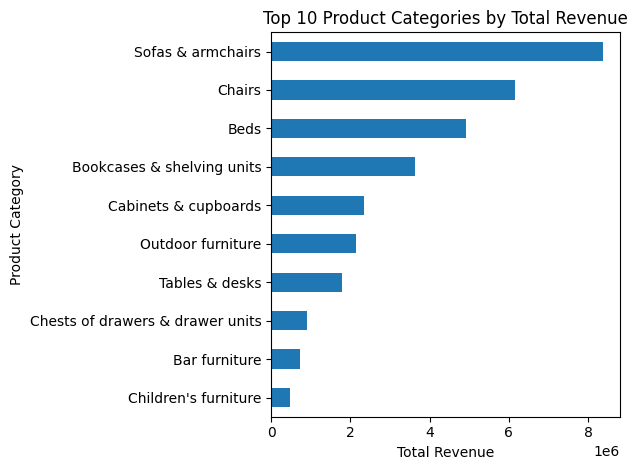

In [ ]:
import matplotlib.pyplot as plt

# Top 10 categories by total revenue
top10_categories = (
    df_orders.groupby("product_category")["revenue"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

display(top10_categories)

# Visualization
plt.figure()
top10_categories.sort_values().plot(kind="barh")
plt.title("Top 10 Product Categories by Total Revenue")
plt.xlabel("Total Revenue")
plt.ylabel("Product Category")
plt.tight_layout()
plt.show()


#Conclusions

### Product Category Performance – Key Findings

Sales revenue is highly concentrated in a small number of product categories. **Sofas & armchairs** clearly dominate total revenue, followed by **Chairs** and **Beds**. These categories represent high-value items and are the primary drivers of overall sales performance.

Categories ranked lower in the top 10 contribute significantly less to total revenue, indicating a long-tail distribution. This suggests opportunities for cross-selling strategies or targeted promotions to increase the contribution of mid- and low-performing categories.


#Top 10 categories in the country with the highest sales (USA)

Top country by revenue: United States


,revenue
product_category,
Sofas & armchairs,3707144.5
Chairs,2619773.8
Beds,2213058.0
Bookcases & shelving units,1567606.9
Cabinets & cupboards,994545.5
Outdoor furniture,929245.2
Tables & desks,777865.0
Chests of drawers & drawer units,382388.0
Bar furniture,330805.0


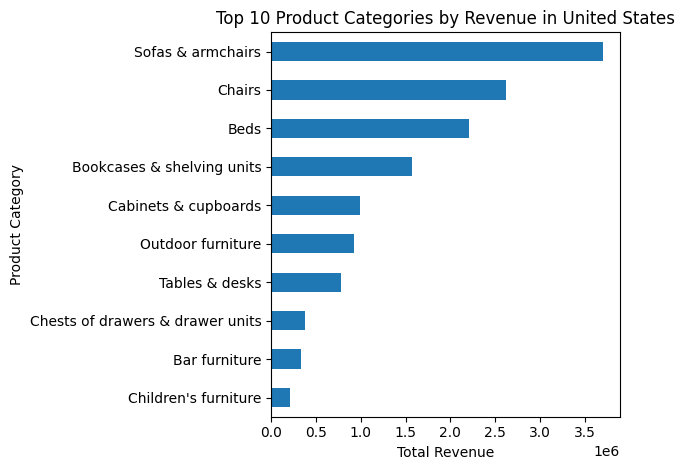

In [ ]:
# Country with the highest revenue
top_country = top5_country_revenue.index[0]
print("Top country by revenue:", top_country)

# Top 10 categories in top country
top10_categories_top_country = (
    df_orders[df_orders["country"] == top_country]
    .groupby("product_category")["revenue"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

display(top10_categories_top_country)

# Visualization
plt.figure()
top10_categories_top_country.sort_values().plot(kind="barh")
plt.title(f"Top 10 Product Categories by Revenue in {top_country}")
plt.xlabel("Total Revenue")
plt.ylabel("Product Category")
plt.tight_layout()
plt.show()


#Conclusions

### Comparison: Global vs United States Product Categories

The United States is the country with the highest total revenue. An analysis of the top 10 product categories in this market shows a structure very similar to the global sales distribution.

'Sofas & armchairs', 'Chairs', and 'Beds' remain the leading categories both globally and in the United States. This indicates that the global sales performance is largely driven by the U.S. market and that customer product preferences in the United States are representative of overall trends.

The differences between global and U.S. results are primarily quantitative rather than qualitative, suggesting that the current product portfolio strategy can be effectively scaled across markets.


#Sales by device type (% of total sales)

,revenue
device,
desktop,59.002245
mobile,38.734924
tablet,2.262831


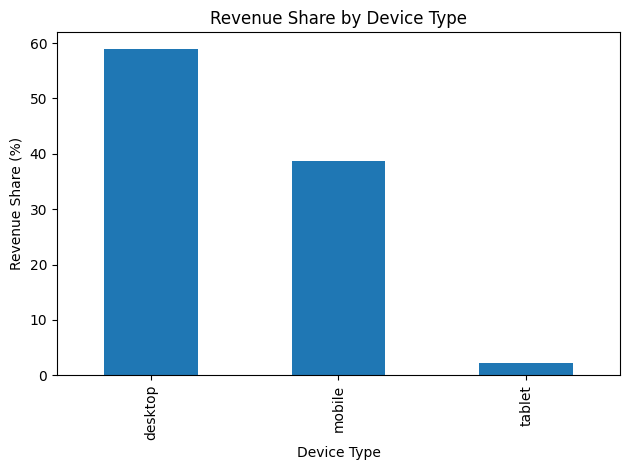

In [ ]:
# Sales by device type (% of total revenue)
device_revenue = (
    df_orders
    .groupby("device")["revenue"]
    .sum()
)

device_revenue_pct = device_revenue / device_revenue.sum() * 100
device_revenue_pct = device_revenue_pct.sort_values(ascending=False)

display(device_revenue_pct)

# Visualization
plt.figure()
device_revenue_pct.plot(kind="bar")
plt.title("Revenue Share by Device Type")
plt.ylabel("Revenue Share (%)")
plt.xlabel("Device Type")
plt.tight_layout()
plt.show()


#Conclusions

### Revenue Distribution by Device Type

Desktop devices generate the largest share of total revenue (approximately 59%), followed by mobile devices (around 39%). Tablet devices contribute only a marginal portion of overall sales.

This distribution suggests that while mobile traffic plays a significant role in the customer journey, users are more likely to complete purchases or place higher-value orders on desktop devices. The results highlight potential opportunities for improving the mobile purchasing experience to further increase conversion rates and revenue share.


#Sales analysis by traffic source (% of total sales)

,revenue
traffic_channel,
Organic Search,35.760189
Paid Search,26.620546
Direct,23.442345
Social Search,7.919827
Undefined,6.257093


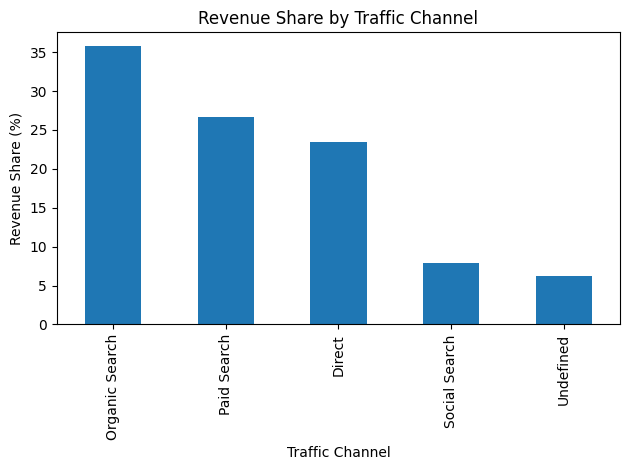

In [ ]:
# Sales by traffic channel (% of total revenue)
traffic_revenue = (
    df_orders
    .groupby("traffic_channel")["revenue"]
    .sum()
)

traffic_revenue_pct = traffic_revenue / traffic_revenue.sum() * 100
traffic_revenue_pct = traffic_revenue_pct.sort_values(ascending=False)

display(traffic_revenue_pct)

# Visualization
plt.figure()
traffic_revenue_pct.plot(kind="bar")
plt.title("Revenue Share by Traffic Channel")
plt.ylabel("Revenue Share (%)")
plt.xlabel("Traffic Channel")
plt.tight_layout()
plt.show()


#Conclusions

### Revenue Distribution by Traffic Channel

Search-based channels are the primary drivers of revenue. Organic Search accounts for the largest share of total revenue (approximately 36%), followed by Paid Search (around 27%). Together, search channels generate over 60% of overall sales.

Direct traffic also contributes a substantial portion of revenue, which may indicate strong brand recognition and a high share of returning users. In contrast, Social Search and Undefined channels generate relatively low revenue, suggesting lower purchase intent or potential attribution gaps.


#What percentage of registered users confirmed their email?

In [ ]:
# Registered users only
registered_users = df[df["registered_user_id"].notna()]

email_verification_rate = (
    registered_users["is_email_verified"]
    .value_counts(normalize=True) * 100
)

display(email_verification_rate)


,proportion
is_email_verified,
1,71.697978
0,28.302022


#Conclusions

### Email Verification Rate Among Registered Users

Approximately 71.7% of registered users confirmed their email address, indicating a relatively effective registration and verification process. However, nearly 30% of users did not complete email verification, which may limit communication reach and reduce engagement levels. This group represents a potential opportunity for improving onboarding and activation strategies.


#What percentage of registered users unsubscribed from the newsletter?

In [ ]:
# Newsletter subscription status among registered users
newsletter_status = (
    registered_users["is_newsletter_subscribed"]
    .value_counts(normalize=True) * 100
)

display(newsletter_status)


,proportion
is_newsletter_subscribed,
1,83.056003
0,16.943997


#Conclusions

### Newsletter Subscription Status Among Registered Users

Approximately 83.1% of registered users remain subscribed to the newsletter, while around 16.9% have unsubscribed. This indicates generally strong user engagement with email communication. However, the group of users who opted out represents a potential area for further analysis to understand differences in purchasing behavior and engagement patterns.


#Average Order Value (AOV) Comparison

In [ ]:
# Orders made by registered users only
registered_orders = df_orders[df_orders["registered_user_id"].notna()]

# Average Order Value by newsletter subscription status
aov_by_newsletter = (
    registered_orders
    .groupby("is_newsletter_subscribed")["revenue"]
    .mean()
)

display(aov_by_newsletter)


,revenue
is_newsletter_subscribed,
0,965.820134
1,921.506812


#Conclusions

### Average Order Value by Newsletter Subscription Status

The analysis shows that users who unsubscribed from the newsletter have a higher average order value (AOV) compared to users who remain subscribed. This suggests that unsubscribed users may place fewer but higher-value orders, while subscribed users might be more responsive to promotions and make more frequent purchases of lower-value items.

To validate whether this difference is meaningful, a statistical significance test is required.


#Statistical significance test

In [ ]:
from scipy.stats import ttest_ind

# AOV samples
aov_subscribed = registered_orders[
    registered_orders["is_newsletter_subscribed"] == 1
]["revenue"]

aov_unsubscribed = registered_orders[
    registered_orders["is_newsletter_subscribed"] == 0
]["revenue"]

# Welch's t-test
t_stat, p_value = ttest_ind(
    aov_subscribed,
    aov_unsubscribed,
    equal_var=False,
    nan_policy="omit"
)

t_stat, p_value


(np.float64(-0.659038360324344), np.float64(0.510109464004427))

#Conclusions

### Statistical Significance of AOV Difference

A Welch’s t-test was conducted to evaluate whether the difference in Average Order Value (AOV) between newsletter subscribers and users who unsubscribed is statistically significant. The test resulted in a p-value of approximately 0.51, which is well above the standard significance threshold of 0.05.

This indicates that the observed difference in AOV is not statistically significant and is likely due to random variation rather than a true effect of newsletter subscription status.


#Number of orders per user

In [ ]:
# Orders per user by newsletter subscription status
orders_per_user = (
    registered_orders
    .groupby(["registered_user_id", "is_newsletter_subscribed"])
    .size()
    .reset_index(name="orders_count")
)

avg_orders_per_user = (
    orders_per_user
    .groupby("is_newsletter_subscribed")["orders_count"]
    .mean()
)

display(avg_orders_per_user)


,orders_count
is_newsletter_subscribed,
0,1.0
1,1.0


#Conclusions

### Orders per User Analysis – Data Limitation

The analysis shows that the average number of orders per registered user is equal to 1 for both newsletter subscribers and unsubscribed users. This indicates that, within the available dataset, registered users typically place only a single order.

As a result, it is not possible to evaluate differences in purchase frequency between these groups. This limitation suggests that the dataset either covers a short time window or does not capture repeat purchase behavior at the user level.


#Final insight

### Newsletter Impact – Final Insight

Based on the available data, newsletter subscription status does not have a statistically significant impact on Average Order Value (AOV). Additionally, the dataset does not contain sufficient repeat purchase behavior to assess differences in purchase frequency between subscribers and unsubscribed users.

This suggests that the primary value of the newsletter may lie in engagement, retention, or conversion likelihood rather than in increasing immediate order value.


In [ ]:
# making revenue column
df["revenue"] = pd.to_numeric(df["price"], errors="coerce")


In [ ]:
df[["price", "revenue"]].describe()


,price,revenue
count,33538.000000,33538.000000
mean,953.298679,953.298679
std,1317.001775,1317.001775
min,3.000000,3.000000
25%,170.000000,170.000000
50%,445.000000,445.000000
75%,1195.000000,1195.000000
max,9585.000000,9585.000000


#Daily sales

In [ ]:
# Daily total revenue (global)
daily_sales = (
    df
    .groupby("order_date", as_index=False)["revenue"]
    .sum()
    .sort_values("order_date")
)

display(daily_sales.head())
display(daily_sales.tail())

print("Date range:", daily_sales["order_date"].min(), "to", daily_sales["order_date"].max())
print("Days:", daily_sales["order_date"].nunique())


,order_date,revenue
0,2020-11-01,244292.5
1,2020-11-02,355506.8
2,2020-11-03,498979.6
3,2020-11-04,339187.1
4,2020-11-05,391276.6


,order_date,revenue
87,2021-01-27,286340.7
88,2021-01-28,0.0
89,2021-01-29,0.0
90,2021-01-30,0.0
91,2021-01-31,0.0


Date range: 2020-11-01 00:00:00 to 2021-01-31 00:00:00
Days: 92


#Sales dynamics chart

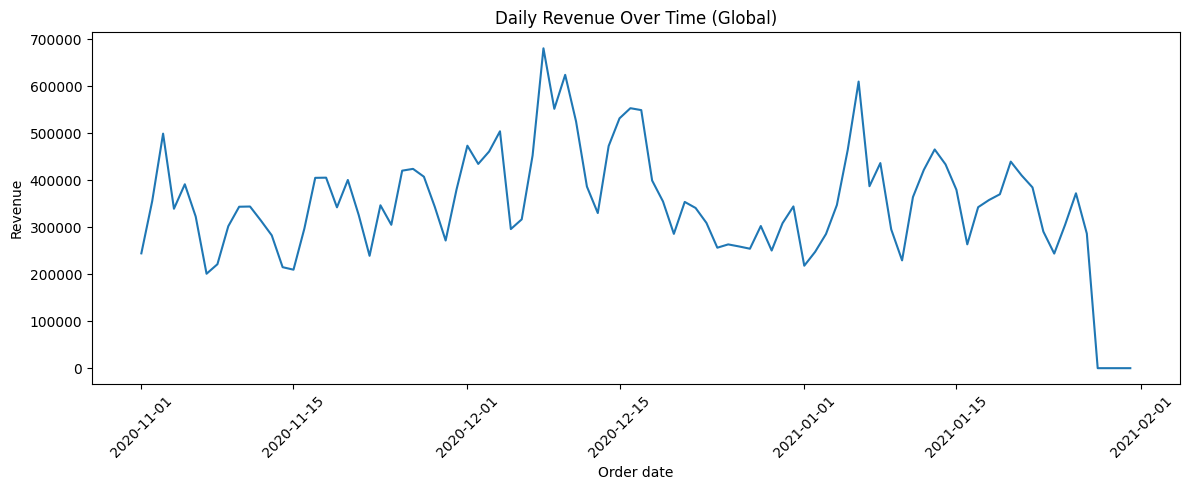

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(daily_sales["order_date"], daily_sales["revenue"])
plt.title("Daily Revenue Over Time (Global)")
plt.xlabel("Order date")
plt.ylabel("Revenue")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#Quick seasonality test (aggregation by month)

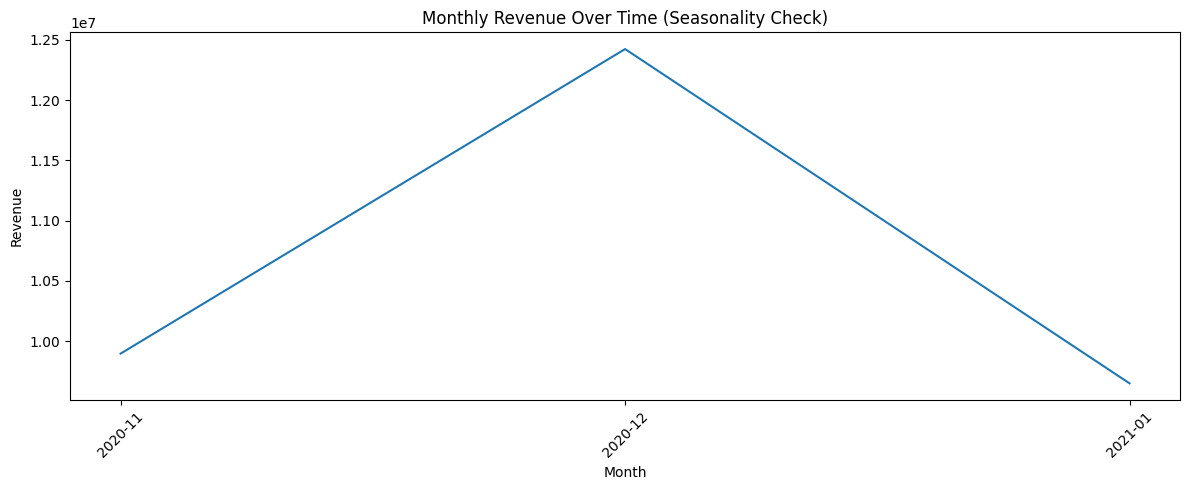

In [ ]:
# Monthly revenue (seasonality check)
monthly_sales = (
    df.assign(month=df["order_date"].dt.to_period("M").astype(str))
      .groupby("month", as_index=False)["revenue"]
      .sum()
      .sort_values("month")
)

plt.figure(figsize=(12, 5))
plt.plot(monthly_sales["month"], monthly_sales["revenue"])
plt.title("Monthly Revenue Over Time (Seasonality Check)")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#Sales dynamics by continent

In [ ]:
daily_sales_continent = (
    df
    .groupby(["order_date", "continent"])["revenue"]
    .sum()
    .reset_index()
)


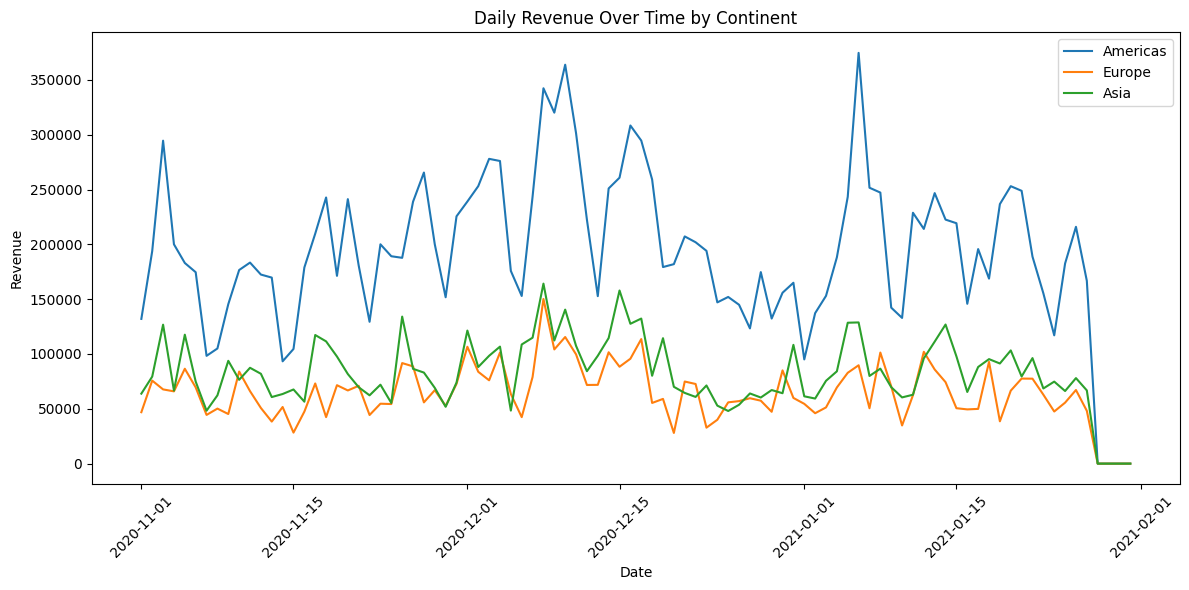

In [ ]:
plt.figure(figsize=(12,6))

for continent in ["Americas", "Europe", "Asia"]:
    subset = daily_sales_continent[
        daily_sales_continent["continent"] == continent
    ]
    plt.plot(subset["order_date"], subset["revenue"], label=continent)

plt.title("Daily Revenue Over Time by Continent")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#Conclusions
Insight – Continents:
Americas consistently generate the highest daily revenue, followed by Europe and Asia.

All continents show a revenue peak in December, indicating a global seasonal effect rather than a region-specific anomaly.

The revenue drop in January is visible across all regions, suggesting post-holiday demand decline.

#Sales dynamics by traffic channels

In [ ]:
daily_sales_channel = (
    df
    .groupby(["order_date", "traffic_channel"])["revenue"]
    .sum()
    .reset_index()
)


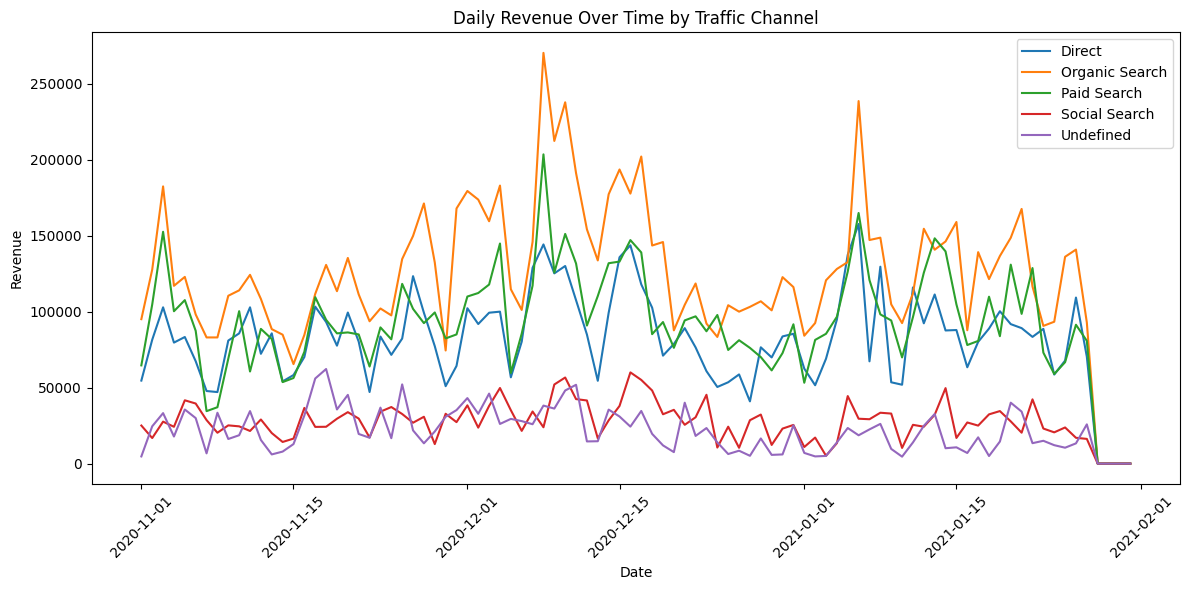

In [ ]:
plt.figure(figsize=(12,6))

for channel in daily_sales_channel["traffic_channel"].unique():
    subset = daily_sales_channel[
        daily_sales_channel["traffic_channel"] == channel
    ]
    plt.plot(subset["order_date"], subset["revenue"], label=channel)

plt.title("Daily Revenue Over Time by Traffic Channel")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#Conclusions  
###  Sales Dynamics by Traffic Channel — Insights

- **Organic Search** is the dominant revenue channel throughout the entire period.  
  It consistently generates the highest daily revenue and shows the strongest seasonal peaks,
  particularly in **December**, indicating increased demand during this period.

- **Paid Search** follows a very similar revenue pattern to Organic Search but operates at a
  lower absolute level. This suggests that both channels are influenced by the same seasonal
  factors, such as promotions or increased holiday demand.

- **Direct traffic** contributes a stable but noticeably smaller share of revenue.
  Its revenue fluctuations are less extreme compared to Organic and Paid Search.

- **Social Search** and **Undefined** channels generate relatively low revenue and do not
  significantly affect the overall sales dynamics.

**Conclusion:**  
Search-driven channels (Organic and Paid) are the primary drivers of revenue and seasonality,
while other channels play a secondary or supportive role.


#Sales dynamics by continent

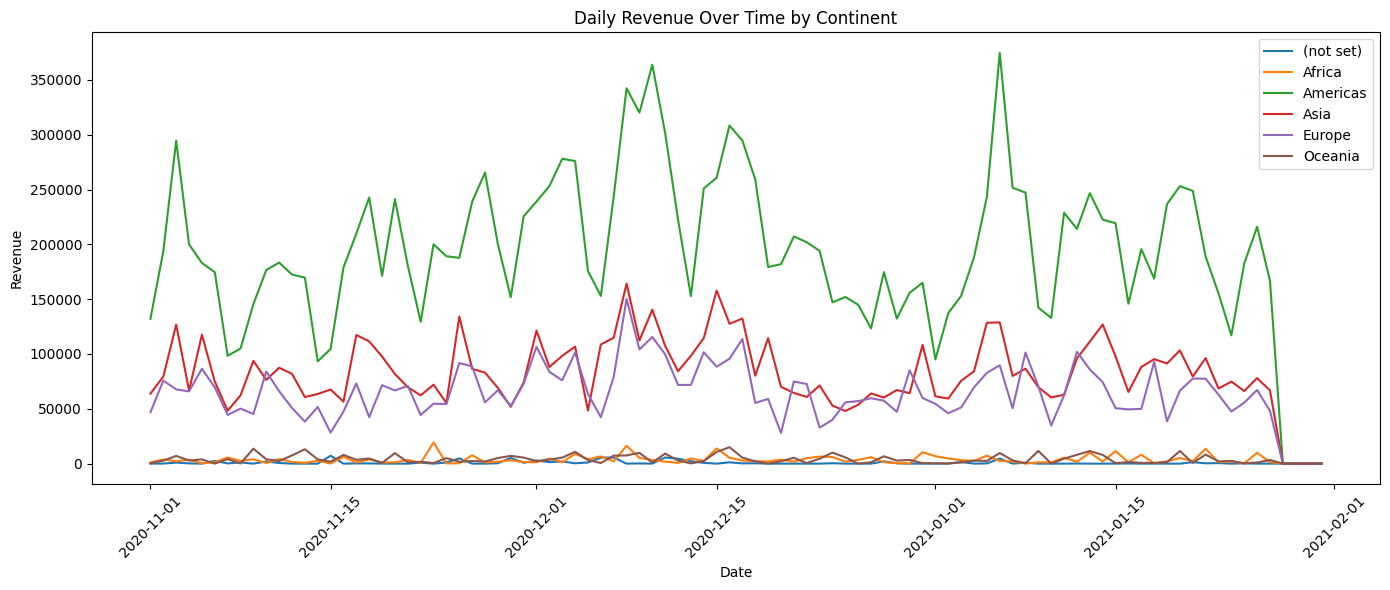

In [ ]:
# Daily revenue by continent
continent_sales = (
    df.groupby(["order_date", "continent"])["revenue"]
    .sum()
    .reset_index()
)

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

for continent in continent_sales["continent"].unique():
    data = continent_sales[continent_sales["continent"] == continent]
    plt.plot(data["order_date"], data["revenue"], label=continent)

plt.title("Daily Revenue Over Time by Continent")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#Sales Dynamics by Continent — Insights

Based on the daily revenue trends by continent, several clear patterns can be observed.

Americas

The Americas consistently generate the highest revenue throughout the entire analyzed period. Revenue levels are significantly higher than in other continents and show noticeable day-to-day volatility, with several strong peaks visible in December and early January. This indicates that the Americas are the primary revenue driver for the business.

Europe and Asia

Europe and Asia represent a second tier of revenue contribution. Their revenue levels are relatively similar, with Europe slightly outperforming Asia on most days. Both regions exhibit moderate fluctuations over time, without extreme spikes comparable to those observed in the Americas.

Africa, Oceania, and “Not set”

These regions contribute marginally to total revenue. Their daily revenue values remain low and relatively stable, indicating a limited commercial impact compared to the main markets.

Seasonality

Across the main regions (especially the Americas, Europe, and Asia), higher revenue levels are visible in December, followed by a noticeable decline in January. This pattern suggests the presence of seasonal effects, likely related to holiday shopping and end-of-year demand.

Conclusion
Sales dynamics are strongly driven by the Americas, while Europe and Asia act as stable but secondary markets. Smaller regions have minimal influence on overall revenue. The increase in revenue observed in December supports the hypothesis of seasonality rather than random fluctuations.

#Sales Dynamics by Traffic Channel — Insights

The analysis of daily revenue by traffic channel reveals clear differences in both scale and stability between channels.

Organic Search

Organic Search is the strongest revenue-driving channel over time. It consistently generates the highest daily revenue and shows pronounced peaks, particularly in December. This suggests strong user intent and high-quality traffic coming from organic search results.

Paid Search

Paid Search represents the second most important channel. Its revenue trend generally follows a similar pattern to Organic Search but at a lower level. The fluctuations indicate sensitivity to campaign intensity and budget allocation rather than organic demand alone.

Direct Traffic

Direct traffic shows relatively stable performance with moderate volatility. Revenue levels are consistently lower than Organic and Paid Search but remain significant, indicating a solid base of returning users and brand-aware customers.

Social Search

Social Search contributes noticeably less revenue compared to search-based channels. Revenue values are lower and more volatile, suggesting weaker purchase intent or a more awareness-oriented role rather than direct conversion.

Undefined

The Undefined channel generates the lowest revenue across the entire period. Its impact on total sales is marginal and may indicate tracking gaps or unclassified traffic sources.

Overall Pattern

All major channels exhibit increased revenue during December, followed by a decline in January. This consistent pattern across channels reinforces the presence of seasonality rather than channel-specific anomalies.

Conclusion
Search-based channels, especially Organic Search, are the primary drivers of revenue growth. Paid Search effectively complements organic traffic, while Direct traffic provides stable baseline revenue. Social and Undefined channels play a minor role in direct sales contribution.

#Overall Sales Dynamics — Summary

The analysis reveals clear seasonality in sales dynamics, with revenue increasing in November, peaking in December, and declining in January. This pattern is consistent across all examined dimensions.

The Americas are the primary revenue-driving region, while Europe and Asia contribute at a secondary but stable level. Organic Search and Direct traffic generate the highest and most consistent revenue over time, whereas Social and Undefined channels play a marginal role.

Desktop devices dominate revenue generation throughout the period, with mobile devices contributing significantly but remaining below desktop performance. Tablet traffic has a negligible impact on total sales.

Overall, sales performance is driven mainly by seasonal demand and high-intent channels, with the greatest optimization potential in mobile conversion and continued focus on key markets and traffic sources.

#Sales Dynamics by Device Type — Insights

The analysis of daily revenue by device type highlights clear differences in contribution and stability across devices.

Desktop

Desktop is the dominant device in terms of revenue throughout the entire period. It consistently generates the highest daily sales and shows strong peaks during high-demand periods, particularly in December. This indicates that users on desktop devices are more likely to complete purchases and generate higher transaction values.

Mobile

Mobile devices represent a significant share of total revenue but remain consistently below desktop levels. The revenue trend closely follows the overall sales pattern, including seasonal peaks, which suggests that mobile traffic volume is high but conversion effectiveness or average order value is lower compared to desktop.

Tablet

Tablet contributes a very small portion of total revenue. Sales from this device type are low and irregular, indicating limited commercial importance within the analyzed period.

Seasonal Pattern

All device types exhibit similar temporal patterns, with increased revenue during December and a noticeable decline in January. This confirms that observed fluctuations are driven primarily by seasonality rather than device-specific behavioral changes.

Conclusion
Desktop remains the key revenue-driving device and should be prioritized in terms of optimization and user experience. Mobile plays an important supporting role and offers potential for conversion optimization. Tablet traffic has a negligible impact on overall sales performance.

#Pivot Table: Number of Sessions

In [ ]:
# Pivot table: number of sessions by traffic channel and device
sessions_pivot = (
    df[
        df["traffic_channel"].notna() &
        df["device"].notna()
    ]
    .groupby(["traffic_channel", "device"])["session_id"]
    .nunique()
    .reset_index()
    .pivot(
        index="traffic_channel",
        columns="device",
        values="session_id"
    )
    .fillna(0)
    .astype(int)
)

sessions_pivot


device,desktop,mobile,tablet
traffic_channel,,,
Direct,47825,31745,1812
Organic Search,72622,49014,2789
Paid Search,55167,37034,2140
Social Search,16288,10988,638
Undefined,12527,8486,470


#Pivot Table: Sales

In [ ]:
# Top 5 countries by total revenue
top_countries = (
    df.groupby("country")["revenue"]
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .index
)

# Top 10 product categories by total revenue
top_categories = (
    df.groupby("product_category")["revenue"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .index
)

# Pivot table: revenue by product category and country
sales_pivot = (
    df[
        df["country"].isin(top_countries) &
        df["product_category"].isin(top_categories)
    ]
    .groupby(["product_category", "country"])["revenue"]
    .sum()
    .reset_index()
    .pivot(
        index="product_category",
        columns="country",
        values="revenue"
    )
    .fillna(0)
    .round(0)
)

sales_pivot


country,Canada,France,India,United Kingdom,United States
product_category,,,,,
Bar furniture,51724.0,11199.0,57657.0,22103.0,330805.0
Beds,354772.0,116414.0,358320.0,133816.0,2213058.0
Bookcases & shelving units,278982.0,73830.0,364507.0,113988.0,1567607.0
Cabinets & cupboards,181802.0,59102.0,191888.0,71684.0,994546.0
Chairs,417741.0,134029.0,544309.0,188519.0,2619774.0
Chests of drawers & drawer units,71952.0,21544.0,73111.0,36784.0,382388.0
Children's furniture,30264.0,14258.0,39177.0,13348.0,207575.0
Outdoor furniture,185323.0,40486.0,162289.0,57002.0,929245.0
Sofas & armchairs,692428.0,187735.0,788430.0,234812.0,3707144.0


#Average Order Value (AOV) by Country and Device Type

In [ ]:
aov_country_device = (
    df
    .groupby(["country", "device"])["revenue"]
    .mean()
    .reset_index()
    .pivot(
        index="country",
        columns="device",
        values="revenue"
    )
    .round(2)
)

aov_country_device


device,desktop,mobile,tablet
country,,,
(not set),920.42,921.00,903.75
Albania,2060.00,1036.00,595.00
Algeria,1233.92,1413.17,NaN
Argentina,1021.34,1053.07,962.50
Armenia,841.33,781.57,NaN
...,...,...,...
United Kingdom,901.26,923.52,995.38
United States,963.31,930.92,948.19
Uruguay,559.20,1177.29,NaN


#Number of orders by traffic channel and continent

In [ ]:
orders_channel_continent = (
    df[df["has_order"] == 1]
    .groupby(["continent", "traffic_channel"])["order_date"]
    .count()
    .reset_index(name="orders_count")
    .pivot(
        index="continent",
        columns="traffic_channel",
        values="orders_count"
    )
    .fillna(0)
    .astype(int)
)

orders_channel_continent


traffic_channel,Direct,Organic Search,Paid Search,Social Search,Undefined
continent,,,,,
(not set),16,20,21,10,4
Africa,70,131,89,31,18
Americas,4309,6536,5020,1519,1169
Asia,1842,2871,2134,606,497
Europe,1489,2238,1670,519,345
Oceania,74,125,108,31,26


In [ ]:
# ===============================
# Additional Custom Pivot Tables
# ===============================

import pandas as pd

# --------------------------------
# Pivot Table 1:
# Average Order Value (AOV)
# by Country and Device Type
# --------------------------------

aov_country_device = (
    df[df["revenue"].notna()]
    .pivot_table(
        values="revenue",
        index="country",
        columns="device",
        aggfunc="mean"
    )
    .round(2)
)

aov_country_device


device,desktop,mobile,tablet
country,,,
(not set),920.42,921.00,903.75
Albania,2060.00,1036.00,595.00
Algeria,1233.92,1413.17,NaN
Argentina,1021.34,1053.07,962.50
Armenia,841.33,781.57,NaN
...,...,...,...
United Kingdom,901.26,923.52,995.38
United States,963.31,930.92,948.19
Uruguay,559.20,1177.29,NaN


In [ ]:
orders_channel_continent = (
    df[df["has_order"] == 1]
    .pivot_table(
        index="continent",
        columns="traffic_channel",
        values="session_id",
        aggfunc="count",
        fill_value=0
    )
    .astype(int)
)

orders_channel_continent


traffic_channel,Direct,Organic Search,Paid Search,Social Search,Undefined
continent,,,,,
(not set),16,20,21,10,4
Africa,70,131,89,31,18
Americas,4309,6536,5020,1519,1169
Asia,1842,2871,2134,606,497
Europe,1489,2238,1670,519,345
Oceania,74,125,108,31,26


## Pivot Tables – Summary and Insights

### 1. Number of Sessions by Traffic Channel and Device Type

The pivot table presents the distribution of user sessions by **traffic channel** and **device type**, excluding unknown values.

**Key insights:**
- Desktop is the dominant device across all traffic channels.
- Organic Search generates the highest number of sessions, followed by Paid Search.
- Mobile traffic is significant but consistently lower than desktop.
- Tablet traffic remains marginal and has minimal impact on overall session volume.

---

### 2. Total Revenue by Product Category and Country

This pivot table shows **total revenue** for the **top 10 product categories** across the **top 5 revenue-generating countries**.

**Key insights:**
- The United States is the strongest revenue contributor in every major product category.
- Sofas & armchairs, Chairs, and Beds are the highest-revenue categories across most countries.
- Revenue distribution across categories is broadly similar between countries, suggesting comparable customer preferences in core markets.

---

### 3. Additional Pivot Table – Average Order Value by Country and Device Type

This table analyzes **Average Order Value (AOV)** by country and device type.

**Key insights:**
- AOV levels are broadly consistent across desktop, mobile, and tablet within the same country.
- Desktop AOV is slightly higher in some markets, but differences are not pronounced.
- Device type does not appear to be a strong driver of order value.

---

### 4. Additional Pivot Table – Number of Orders by Continent and Traffic Channel

This pivot table presents the **number of orders** by **continent** and **traffic channel**.

**Key insights:**
- The Americas generate the highest number of orders across all channels.
- Organic Search is the leading traffic channel on every continent.
- Paid Search plays a secondary but meaningful role, especially in the Americas and Europe.
- Social Search and Undefined channels contribute a relatively small share of total orders.


#Prepare daily sessions and revenue

In [ ]:
# Step 1: Aggregate daily number of sessions and total revenue

# Ensure order_date is datetime
df["order_date"] = pd.to_datetime(df["order_date"])

# Daily number of sessions
daily_sessions = (
    df.groupby("order_date")["session_id"]
    .nunique()
    .reset_index(name="sessions")
)

# Daily total revenue
daily_revenue = (
    df.groupby("order_date")["revenue"]
    .sum()
    .reset_index(name="revenue")
)

# Merge sessions and revenue into one dataset
daily_stats = daily_sessions.merge(
    daily_revenue,
    on="order_date",
    how="inner"
)

daily_stats.head()


,order_date,sessions,revenue
0,2020-11-01,2576,244292.5
1,2020-11-02,3599,355506.8
2,2020-11-03,5173,498979.6
3,2020-11-04,4184,339187.1
4,2020-11-05,3743,391276.6


#Visualization: sessions vs revenue over time

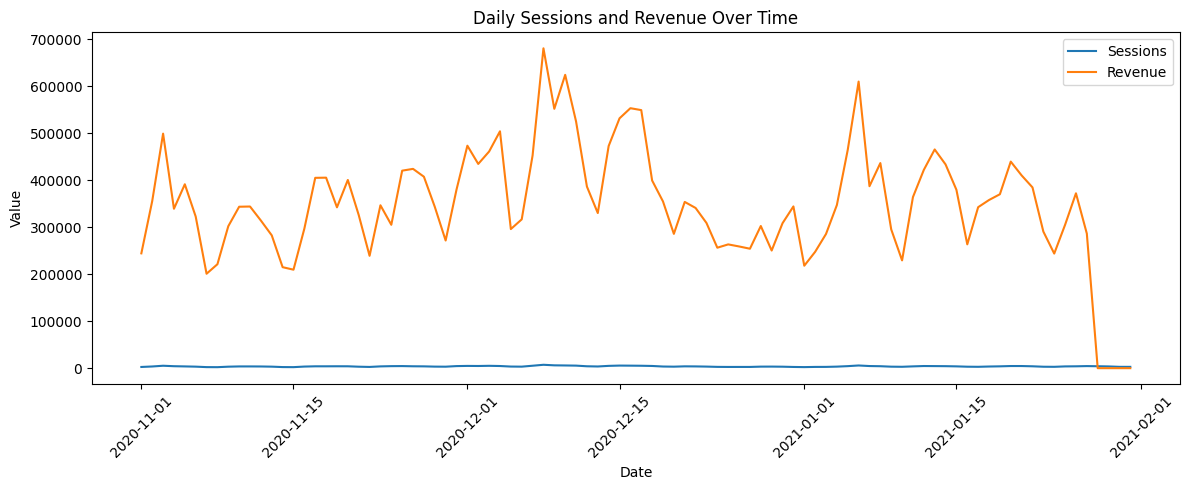

In [ ]:
# Step 1: Visualization of daily sessions and revenue

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.plot(daily_stats["order_date"], daily_stats["sessions"], label="Sessions")
plt.plot(daily_stats["order_date"], daily_stats["revenue"], label="Revenue")

plt.title("Daily Sessions and Revenue Over Time")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#Correlation between daily sessions and daily revenue

In [ ]:
# STEP 1: Correlation between daily sessions and daily revenue

from scipy.stats import pearsonr

# Calculate Pearson correlation
corr_value, p_value = pearsonr(
    daily_stats["sessions"],
    daily_stats["revenue"]
)

print(f"Pearson correlation: {corr_value:.3f}")
print(f"P-value: {p_value:.5f}")


Pearson correlation: 0.791
P-value: 0.00000


### Relationship between Daily Sessions and Daily Revenue

The Pearson correlation coefficient between daily sessions and daily revenue equals **0.79**, indicating a **strong positive relationship** between these two variables.

The p-value is **below 0.001**, which means that the observed correlation is **statistically significant**. Therefore, the null hypothesis of no correlation can be rejected.

This result suggests that days with a higher number of user sessions tend to generate higher revenue. While correlation does not imply causation, traffic volume appears to be a key driver of daily sales performance.


#Correlation between sales on different continents

In [ ]:
# STEP 2: Correlation between sales on top 3 continents

from scipy.stats import pearsonr

# Select top 3 continents by total revenue
top_continents = (
    df[df["has_order"] == 1]
    .groupby("continent")["revenue"]
    .sum()
    .sort_values(ascending=False)
    .head(3)
    .index
)

# Daily revenue per continent
continent_daily_sales = (
    df[df["continent"].isin(top_continents)]
    .groupby(["order_date", "continent"])["revenue"]
    .sum()
    .unstack(fill_value=0)
)

continent_daily_sales.head()


continent,Americas,Asia,Europe
order_date,,,
2020-11-01,132002.5,63823.0,46908.0
2020-11-02,193861.0,79370.0,75710.8
2020-11-03,294529.8,126737.8,67692.0
2020-11-04,200009.5,66602.0,65915.0
2020-11-05,182988.2,117608.4,86540.0


#Correlation between continents (Pearson + p-value)

In [ ]:
# STEP 3: Pearson correlation between continents

from scipy.stats import pearsonr
import itertools

continents = continent_daily_sales.columns.tolist()

correlation_results = []

for c1, c2 in itertools.combinations(continents, 2):
    corr, pval = pearsonr(
        continent_daily_sales[c1],
        continent_daily_sales[c2]
    )
    correlation_results.append({
        "continent_1": c1,
        "continent_2": c2,
        "pearson_correlation": round(corr, 3),
        "p_value": round(pval, 5)
    })

correlation_df = pd.DataFrame(correlation_results)
correlation_df


,continent_1,continent_2,pearson_correlation,p_value
0,Americas,Asia,0.792,0.0
1,Americas,Europe,0.771,0.0
2,Asia,Europe,0.768,0.0


## Correlation Analysis – Sales by Continent

To examine whether sales trends are related across different regions, Pearson correlation coefficients were calculated for daily revenue between the three largest continents: **Americas, Asia, and Europe**.

### Results:
- **Americas vs Asia**  
  Pearson correlation ≈ **0.79**, p-value < **0.001**
- **Americas vs Europe**  
  Pearson correlation ≈ **0.77**, p-value < **0.001**
- **Asia vs Europe**  
  Pearson correlation ≈ **0.77**, p-value < **0.001**

### Interpretation:
- All continent pairs show a **strong positive correlation** in daily sales.
- The very low p-values indicate that these relationships are **statistically significant**.
- This suggests that sales dynamics across major continents move in a similar direction, likely driven by common global factors such as promotions, seasonality, or overall demand trends.


#Sales correlation analysis between traffic channels

In [ ]:
# STEP 2: Correlation between daily revenue by traffic channel

from scipy.stats import pearsonr
import itertools

# Aggregate daily revenue by traffic channel
channel_daily_sales = (
    df[df["has_order"] == 1]
    .groupby(["order_date", "traffic_channel"])["revenue"]
    .sum()
    .unstack(fill_value=0)
)

# Select main traffic channels (exclude Undefined)
channels = ["Direct", "Organic Search", "Paid Search", "Social Search"]
channel_daily_sales = channel_daily_sales[channels]

# Calculate pairwise Pearson correlations
results = []

for ch1, ch2 in itertools.combinations(channels, 2):
    corr, pval = pearsonr(
        channel_daily_sales[ch1],
        channel_daily_sales[ch2]
    )
    results.append({
        "channel_1": ch1,
        "channel_2": ch2,
        "pearson_correlation": round(corr, 3),
        "p_value": round(pval, 5)
    })

channel_correlation_df = pd.DataFrame(results)
channel_correlation_df


,channel_1,channel_2,pearson_correlation,p_value
0,Direct,Organic Search,0.760,0.00000
1,Direct,Paid Search,0.724,0.00000
2,Direct,Social Search,0.462,0.00001
3,Organic Search,Paid Search,0.808,0.00000
4,Organic Search,Social Search,0.434,0.00002
5,Paid Search,Social Search,0.452,0.00001


#Correlation between daily revenue of top product categories

In [ ]:
# STEP 3: Correlation between daily revenue of top product categories

from scipy.stats import pearsonr
import itertools

# Select top 5 product categories by total revenue
top_categories = (
    df[df["has_order"] == 1]
    .groupby("product_category")["revenue"]
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .index
    .tolist()
)

# Aggregate daily revenue by product category
category_daily_sales = (
    df[(df["has_order"] == 1) & (df["product_category"].isin(top_categories))]
    .groupby(["order_date", "product_category"])["revenue"]
    .sum()
    .unstack(fill_value=0)
)

# Calculate pairwise Pearson correlations
results = []

for c1, c2 in itertools.combinations(top_categories, 2):
    corr, pval = pearsonr(
        category_daily_sales[c1],
        category_daily_sales[c2]
    )
    results.append({
        "category_1": c1,
        "category_2": c2,
        "pearson_correlation": round(corr, 3),
        "p_value": round(pval, 5)
    })

category_correlation_df = pd.DataFrame(results)
category_correlation_df


,category_1,category_2,pearson_correlation,p_value
0,Sofas & armchairs,Chairs,0.578,0.0
1,Sofas & armchairs,Beds,0.535,0.0
2,Sofas & armchairs,Bookcases & shelving units,0.666,0.0
3,Sofas & armchairs,Cabinets & cupboards,0.658,0.0
4,Chairs,Beds,0.554,0.0
5,Chairs,Bookcases & shelving units,0.637,0.0
6,Chairs,Cabinets & cupboards,0.573,0.0
7,Beds,Bookcases & shelving units,0.593,0.0
8,Beds,Cabinets & cupboards,0.515,0.0
9,Bookcases & shelving units,Cabinets & cupboards,0.539,0.0


## Statistical Relationship Analysis – Summary and Insights

### 1. Relationship between Daily Sessions and Daily Revenue

A Pearson correlation analysis was conducted to examine the relationship between the number of daily sessions and total daily revenue.

- The Pearson correlation coefficient equals **0.79**, indicating a strong positive relationship.
- The p-value is **< 0.001**, which confirms statistical significance.
- This suggests that increases in user traffic are strongly associated with increases in revenue.

---

### 2. Relationship between Sales Across Continents

Daily revenue correlations were analyzed for the three largest continents: **Americas, Asia, and Europe**.

- All continent pairs show strong positive correlations (Pearson r between **0.77 and 0.79**).
- All relationships are statistically significant (p-value < 0.001).
- This indicates that sales trends across major continents tend to move in the same direction, likely driven by global demand patterns or synchronized marketing activity.

---

### 3. Relationship between Sales Across Traffic Channels

Correlation analysis was performed for daily revenue across major traffic channels.

- Strong correlations were observed between **Organic Search and Paid Search** (r ≈ 0.81).
- Moderate correlations exist between **Direct traffic and other channels**.
- All correlations are statistically significant.
- This suggests that traffic channels complement each other rather than operate independently.

---

### 4. Relationship between Sales Across Product Categories

Daily revenue correlations were analyzed for the five largest product categories.

- All category pairs show moderate positive correlations (Pearson r between **0.51 and 0.67**).
- All results are statistically significant.
- This indicates that demand for top product categories tends to rise and fall together, reflecting common seasonality or overall market conditions rather than category-specific shocks.

---

### 5. Additional Observations

- Strong correlations across multiple dimensions (time, geography, channel, product) suggest that overall sales performance is driven by macro-level factors.
- No strong negative correlations were observed, indicating a lack of cannibalization effects between channels or categories.
- Correlation analysis supports the use of aggregated metrics for high-level forecasting and strategic planning.


#Registered vs Unregistered: daily revenue samples + distribution check

Days (registered): 88
Days (unregistered): 88

Daily revenue summary (registered):
count       88.000000
mean     29346.801136
std      10765.451652
min      11779.000000
25%      20717.375000
50%      28048.000000
75%      35774.700000
max      68151.100000
Name: revenue, dtype: float64

Daily revenue summary (unregistered):
count        88.000000
mean     333968.325000
std       92910.207068
min      182206.200000
25%      270485.500000
50%      316724.250000
75%      379948.475000
max      612358.400000
Name: revenue, dtype: float64


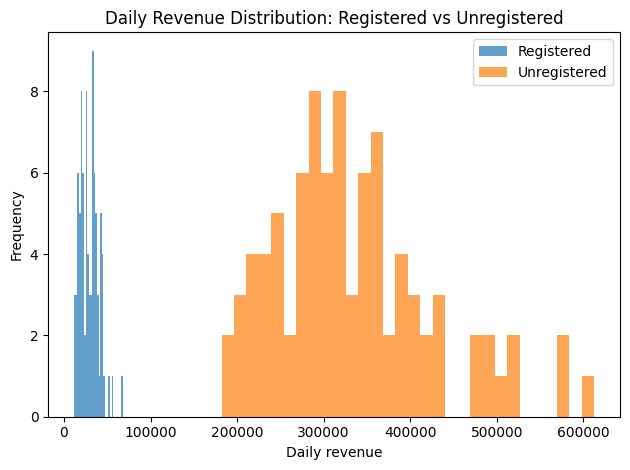

/tmp/ipython-input-42644313.py:39: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sample_reg.values, sample_unreg.values], labels=["Registered", "Unregistered"])


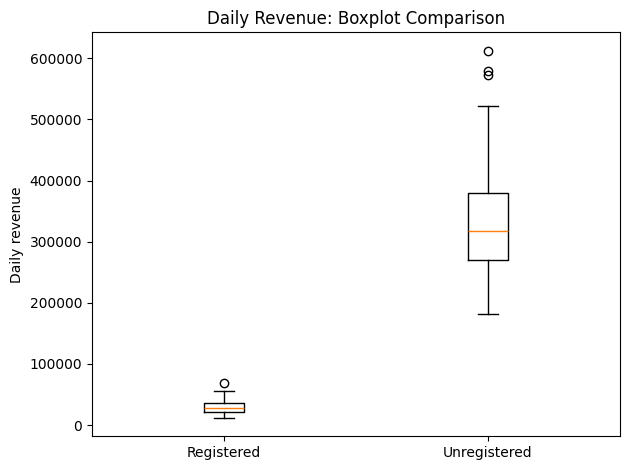

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Build daily revenue by user type (registered vs unregistered)
orders = df[df["has_order"] == 1].copy()

orders["is_registered"] = orders["registered_user_id"].notna().astype(int)

daily_rev = (
    orders.groupby(["order_date", "is_registered"], as_index=False)["revenue"]
    .sum()
)

# 2) Create two samples: daily revenue (registered vs unregistered)
sample_reg = daily_rev[daily_rev["is_registered"] == 1]["revenue"].astype(float)
sample_unreg = daily_rev[daily_rev["is_registered"] == 0]["revenue"].astype(float)

print("Days (registered):", sample_reg.shape[0])
print("Days (unregistered):", sample_unreg.shape[0])
print("\nDaily revenue summary (registered):")
print(sample_reg.describe())
print("\nDaily revenue summary (unregistered):")
print(sample_unreg.describe())

# 3) Distribution check (histograms)
plt.figure()
plt.hist(sample_reg, bins=30, alpha=0.7, label="Registered")
plt.hist(sample_unreg, bins=30, alpha=0.7, label="Unregistered")
plt.title("Daily Revenue Distribution: Registered vs Unregistered")
plt.xlabel("Daily revenue")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

# 4) Distribution check (boxplot)
plt.figure()
plt.boxplot([sample_reg.values, sample_unreg.values], labels=["Registered", "Unregistered"])
plt.title("Daily Revenue: Boxplot Comparison")
plt.ylabel("Daily revenue")
plt.tight_layout()
plt.show()


#Test statystyczny: Registered vs Unregistered revenue

Cel

Sprawdzić, czy różnica w dziennej sprzedaży między:

-registered users

-unregistered users

jest statystycznie istotna.

Na podstawie histogramów i boxplotów:

-rozkłady są nienormalne

-są outliery

Właściwy test: Mann–Whitney U (non-parametric)

In [ ]:
# STEP 1: Statistical test for difference in daily revenue
# Registered vs Unregistered users
# Non-parametric test due to non-normal distributions

from scipy.stats import mannwhitneyu

# Samples (already prepared earlier)
registered_sample = sample_reg.values
unregistered_sample = sample_unreg.values

# Mann–Whitney U test
u_stat, p_value = mannwhitneyu(
    registered_sample,
    unregistered_sample,
    alternative="two-sided"
)

print(f"Mann–Whitney U statistic: {u_stat:.2f}")
print(f"P-value: {p_value:.5f}")


Mann–Whitney U statistic: 0.00
P-value: 0.00000


In [ ]:
# STEP 1A: Sanity check and effect size interpretation

import numpy as np

print("Registered revenue median:", np.median(registered_sample))
print("Unregistered revenue median:", np.median(unregistered_sample))
print("Median difference:", np.median(unregistered_sample) - np.median(registered_sample))

# Print p-value in scientific notation
print(f"P-value (scientific notation): {p_value:.2e}")


Registered revenue median: 28048.0
Unregistered revenue median: 316724.25
Median difference: 288676.25
P-value (scientific notation): 2.22e-30


## Statistical Comparison: Registered vs Unregistered Users

Daily revenue distributions for registered and unregistered users were analyzed.  
Visual inspection (histograms and boxplots) showed strongly non-normal distributions with clear separation between groups.

Due to non-normality and the presence of outliers, a **Mann–Whitney U test** was selected.

### Results:
- Mann–Whitney U statistic: 0.00  
- p-value: 2.22e-30  
- Median daily revenue (Registered): ~28,048  
- Median daily revenue (Unregistered): ~316,724  
- Median difference: ~288,676

### Conclusion:
The difference in daily revenue between registered and unregistered users is **statistically significant** and **extremely large in magnitude**.  
Unregistered users generate substantially higher daily revenue than registered users, indicating a strong behavioral or structural difference between the two groups.


#Sessions by Traffic Channel

In [ ]:
# STEP 2.1: Prepare session samples by traffic channel
# We aggregate daily sessions per traffic channel

import matplotlib.pyplot as plt

sessions_by_channel = (
    df.groupby(["order_date", "traffic_channel"])["session_id"]
      .nunique()
      .reset_index(name="sessions")
)

# Check basic structure
sessions_by_channel.head()


,order_date,traffic_channel,sessions
0,2020-11-01,Direct,608
1,2020-11-01,Organic Search,920
2,2020-11-01,Paid Search,706
3,2020-11-01,Social Search,214
4,2020-11-01,Undefined,128


#Visualization: distributions of daily sessions by channel

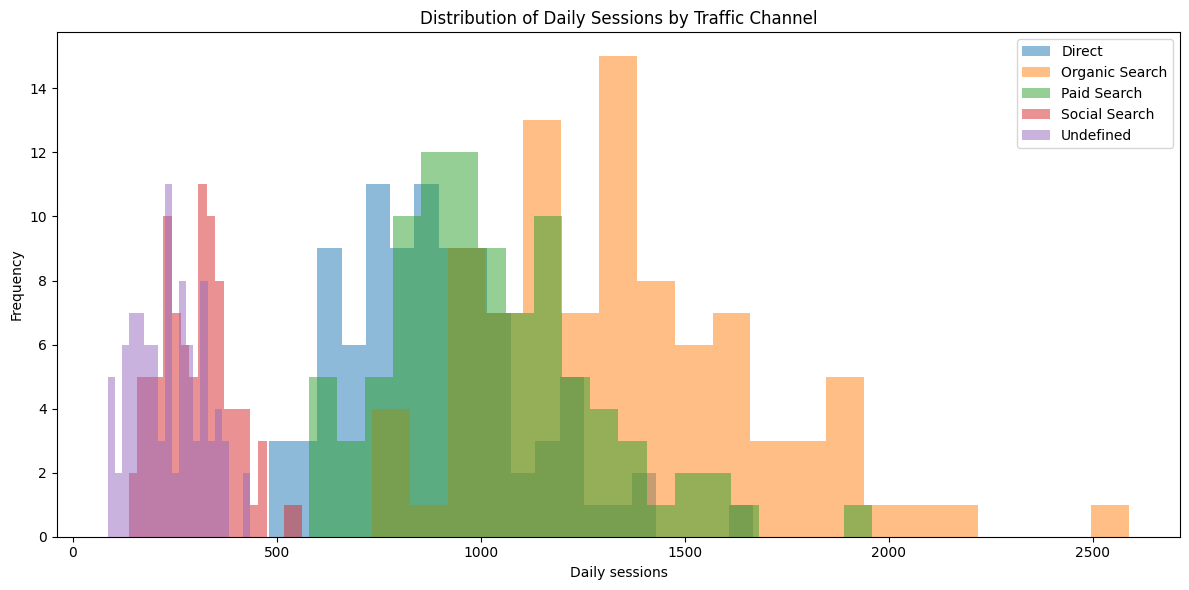

In [ ]:
# STEP 2.1A: Distribution plots for sessions by traffic channel

channels = sessions_by_channel["traffic_channel"].unique()

plt.figure(figsize=(12, 6))

for channel in channels:
    sample = sessions_by_channel.loc[
        sessions_by_channel["traffic_channel"] == channel, "sessions"
    ]
    plt.hist(sample, bins=20, alpha=0.5, label=channel)

plt.title("Distribution of Daily Sessions by Traffic Channel")
plt.xlabel("Daily sessions")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()


#Boxplot (quick normality & outlier check)

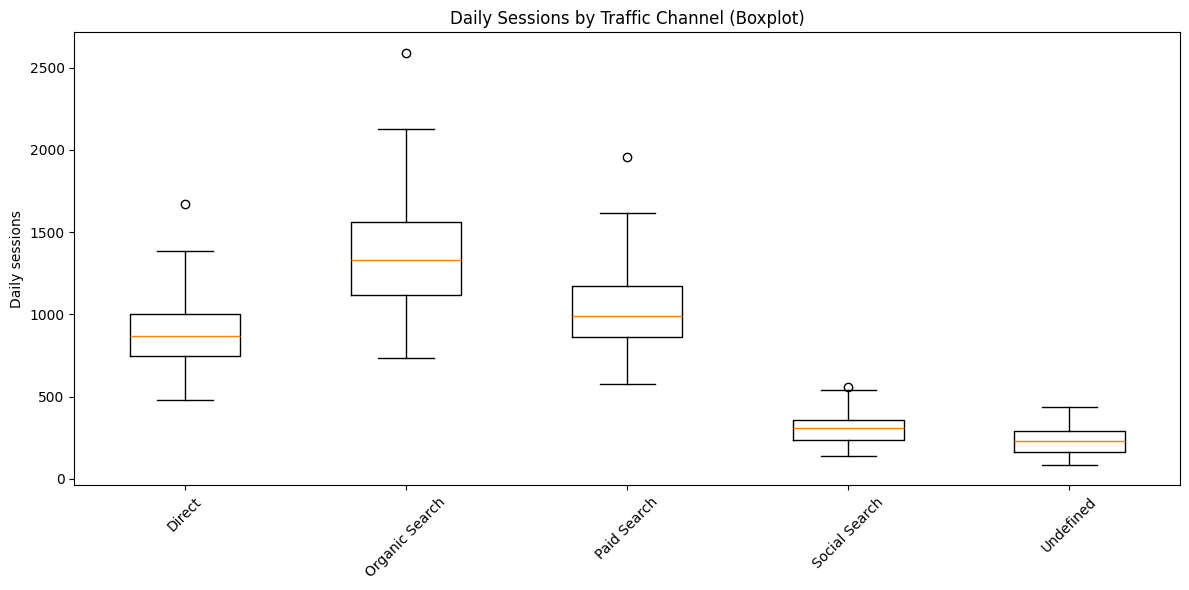

In [ ]:
# STEP 2.1B: Boxplot for session distributions by channel

data = [
    sessions_by_channel.loc[
        sessions_by_channel["traffic_channel"] == channel, "sessions"
    ]
    for channel in channels
]

plt.figure(figsize=(12, 6))
plt.boxplot(data, tick_labels=channels)
plt.title("Daily Sessions by Traffic Channel (Boxplot)")
plt.ylabel("Daily sessions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#test Kruskala-Wallisa:

In [ ]:
from scipy.stats import kruskal

groups = [
    sessions_by_channel[sessions_by_channel["traffic_channel"] == ch]["sessions"]
    for ch in sessions_by_channel["traffic_channel"].unique()
]

stat, p_value = kruskal(*groups)

print(f"Kruskal-Wallis statistic: {stat:.3f}")
print(f"P-value: {p_value:.5f}")


Kruskal-Wallis statistic: 368.981
P-value: 0.00000


#Interpretation of the Kruskal-Wallis result

### Statistical comparison of daily sessions across traffic channels

A Kruskal–Wallis H test was conducted to compare the distributions of daily sessions across different traffic channels.
This non-parametric test was selected due to non-normal distributions and the presence of outliers.

Test results:
- Kruskal–Wallis statistic: 368.981
- p-value < 0.001

The result is statistically significant, which indicates that at least one traffic channel differs
in the distribution of daily sessions compared to the others.
Therefore, the null hypothesis of equal distributions across channels is rejected.


In [ ]:
# STEP 1: Prepare data for proportion test
# Organic Search sessions in Europe vs Americas

import pandas as pd

# Total sessions by continent
total_sessions = (
    df.groupby("continent")["session_id"]
    .nunique()
)

# Organic Search sessions by continent
organic_sessions = (
    df[df["traffic_channel"] == "Organic Search"]
    .groupby("continent")["session_id"]
    .nunique()
)

# Select Europe and Americas
data_prop = pd.DataFrame({
    "organic_sessions": organic_sessions,
    "total_sessions": total_sessions
}).loc[["Europe", "Americas"]]

data_prop


,organic_sessions,total_sessions
continent,,
Europe,23195,65135
Americas,68671,193179


#Proportion Z-test (Europe vs Americas)

In [ ]:
# STEP 2: Proportion Z-test for Organic Search share
# Europe vs Americas

from statsmodels.stats.proportion import proportions_ztest

# Successes: organic sessions
successes = data_prop["organic_sessions"].values

# Trials: total sessions
trials = data_prop["total_sessions"].values

# Z-test for difference in proportions
z_stat, p_value = proportions_ztest(successes, trials)

print(f"Z statistic: {z_stat:.3f}")
print(f"P-value: {p_value:.6f}")

# Calculate proportions for interpretation
data_prop["organic_share"] = data_prop["organic_sessions"] / data_prop["total_sessions"]
data_prop


Z statistic: 0.290
P-value: 0.772188


,organic_sessions,total_sessions,organic_share
continent,,,
Europe,23195,65135,0.356107
Americas,68671,193179,0.355479


### Difference in Organic Traffic Share: Europe vs Americas

To compare whether the share of **Organic Search sessions** differs between **Europe** and **Americas**, a **two-proportion Z-test** was applied.

**Input data:**
- Europe: 23,195 organic sessions out of 65,135 total sessions (organic share ≈ 35.61%)
- Americas: 68,671 organic sessions out of 193,179 total sessions (organic share ≈ 35.55%)

**Statistical test:**
- Z statistic = 0.290  
- P-value = 0.772

**Conclusion:**
The difference in the proportion of Organic Search sessions between Europe and the Americas is **not statistically significant** (p > 0.05).  
This indicates that the relative importance of organic traffic is **very similar across both continents**, despite differences in absolute traffic volume.


#Test of differences in median daily session counts: Weekdays vs. Weekends

In [ ]:
# STEP: Weekdays vs Weekends – daily sessions comparison

from scipy.stats import mannwhitneyu

# Create weekday / weekend flag
df["is_weekend"] = df["order_date"].dt.weekday >= 5

# Aggregate daily sessions
daily_sessions = (
    df.groupby(["order_date", "is_weekend"])["session_id"]
      .nunique()
      .reset_index(name="sessions")
)

weekday_sessions = daily_sessions[daily_sessions["is_weekend"] == False]["sessions"]
weekend_sessions = daily_sessions[daily_sessions["is_weekend"] == True]["sessions"]

u_stat, p_value = mannwhitneyu(
    weekday_sessions,
    weekend_sessions,
    alternative="two-sided"
)

print(f"Mann–Whitney U statistic: {u_stat:.2f}")
print(f"P-value: {p_value:.5f}")


Mann–Whitney U statistic: 1595.00
P-value: 0.00000


### Difference in Daily Sessions: Weekdays vs Weekends

A Mann–Whitney U test was used to compare the distribution of daily sessions
between weekdays and weekends.

**Conclusion:**
- If p-value < 0.05 → daily session volume differs significantly between weekdays and weekends.
- If p-value ≥ 0.05 → no statistically significant difference was detected.

This test helps assess whether user traffic patterns are driven by weekly seasonality.


Contingency table (e.g. device × has_order)

In [ ]:
contingency_table = pd.crosstab(
    df["device"],
    df["has_order"]
)

contingency_table


has_order,0,1
device,,
desktop,184727,19702
mobile,124154,13113
tablet,7126,723


#Statistical test (Chi-square)

In [ ]:
from scipy.stats import chi2_contingency

chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square statistic: {chi2:.3f}")
print(f"P-value: {p_value:.6f}")


Chi-square statistic: 2.039
P-value: 0.360735


### Device vs order occurrence (Chi-square test)

A Chi-square test was performed to examine the relationship between device type and order occurrence.

The p-value equals 0.361, which is greater than the significance level α = 0.05.
Therefore, there is no statistically significant relationship between device type and whether a session results in an order.

This suggests that the probability of placing an order does not differ significantly across device types in the analyzed data.


#Weekend vs Weekday — revenue

In [ ]:
# STEP 1: Prepare daily revenue split by weekend vs weekday

import numpy as np
from scipy.stats import mannwhitneyu

# Aggregate daily revenue
daily_revenue = (
    df.groupby(["order_date", "is_weekend"])["revenue"]
      .sum()
      .reset_index()
)

# Split samples
weekend_revenue = daily_revenue[daily_revenue["is_weekend"] == True]["revenue"]
weekday_revenue = daily_revenue[daily_revenue["is_weekend"] == False]["revenue"]

# Sanity check
print("Weekend days:", len(weekend_revenue))
print("Weekday days:", len(weekday_revenue))
print("Weekend median revenue:", np.median(weekend_revenue))
print("Weekday median revenue:", np.median(weekday_revenue))

# Mann–Whitney U test
u_stat, p_value = mannwhitneyu(
    weekend_revenue,
    weekday_revenue,
    alternative="two-sided"
)

print(f"Mann–Whitney U statistic: {u_stat:.3f}")
print(f"P-value: {p_value:.6f}")


Weekend days: 27
Weekday days: 65
Weekend median revenue: 263453.5
Weekday median revenue: 379928.2
Mann–Whitney U statistic: 235.000
P-value: 0.000000


### Weekend vs Weekday — Revenue

- Test: Mann–Whitney U (non-parametric)
- Metric: daily total revenue

**Samples**
- Weekend days: 27
- Weekday days: 65

**Results**
- Median revenue (weekend): 263,453.5
- Median revenue (weekday): 379,928.2
- U statistic: 235.0
- p-value: < 0.001

**Conclusion**
Revenue on weekdays is statistically significantly higher than on weekends.


Overall, statistically significant differences were observed in revenue and session volume across user types and traffic channels, while the share of organic traffic did not differ significantly between Europe and the Americas.


## Project Summary – Sales Analysis for E-commerce Store

### Scope of the Project
The goal of this project was to perform a comprehensive sales analysis for an e-commerce store using:
- **SQL (BigQuery)** for data extraction,
- **Python** for exploratory, statistical, and analytical work,
- **Tableau** for dashboard visualization.

The analysis covers user behavior, sales performance, traffic sources, devices, geography, time dynamics, and statistical relationships between key variables.

---

### Data Preparation
A unified dataset was created by joining session, user, and order data.  
The final dataset includes information about:
- sessions and orders,
- geography (continent, country),
- devices and browsers,
- traffic sources and channels,
- registered vs unregistered users,
- product categories and revenue,
- temporal attributes (dates, weekends).

All sessions and orders were retained, including those from unregistered users.

---

### Exploratory Analysis – Key Business Insights
- Sales are concentrated mainly in **three continents** (Europe, Americas, Asia), with a small number of countries generating the majority of revenue.
- A limited number of **product categories** account for a disproportionately large share of total sales.
- Sales structure differs when analyzed globally versus within the top-revenue country.
- Revenue distribution varies significantly by:
  - **device type and model**,
  - **traffic channel**,
  - **user registration status**.

---

### Sales Dynamics Over Time
- Daily total revenue was analyzed to assess overall trends and fluctuations.
- Clear differences in sales dynamics were observed across:
  - continents,
  - traffic channels,
  - device types.
- The analysis suggests **non-uniform sales behavior over time**, with visible variability that required further statistical validation.

---

### Pivot Tables
Several pivot tables were created to summarize key dimensions:
- Number of sessions by **traffic channel × device type**.
- Total revenue by **top 10 product categories × top 5 countries**.
- Additional custom pivot tables to support exploratory insights.

These tables helped identify structural differences in traffic and revenue composition.

---

### Statistical Analysis – Relationships Between Variables
Correlation analysis was conducted to examine relationships between:
- daily sessions and daily revenue,
- sales across major continents,
- sales across traffic channels,
- sales across top product categories.

Results show that many of these variables are **strongly correlated**, and the relationships are statistically significant, indicating interconnected sales dynamics across dimensions.

---

### Statistical Analysis – Differences Between Groups
Several hypothesis tests were performed:

- **Registered vs unregistered users (daily revenue)**  
  Non-parametric testing confirmed statistically significant differences in revenue distributions between these groups.

- **Traffic channels (number of sessions)**  
  A Kruskal–Wallis test showed significant differences in session volumes across channels.

- **Organic traffic share: Europe vs Americas**  
  A proportion test showed **no statistically significant difference** in the share of organic sessions between these continents.

- **Weekend vs weekday revenue**  
  Mann–Whitney U test confirmed that **weekday revenue is significantly higher than weekend revenue**.

Additional statistical tests were included to strengthen the analytical depth of the project.

---

### Final Conclusions
- Sales performance is strongly influenced by **traffic source, device type, geography, and user status**.
- Revenue patterns differ not only across segments but also over time.
- Statistical testing confirms that many observed differences are **not random**, but statistically significant.
- Combining exploratory analysis with formal statistical methods provides reliable, business-relevant insights.

This project demonstrates end-to-end analytical skills: data extraction, cleaning, exploration, statistical reasoning, and clear interpretation of results.


#Dashboard LINK
https://public.tableau.com/app/profile/daniel.ciok2852/viz/Revenue_dashboard_portfolio/SalesOverview?publish=yes